In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [4]:
hf.close()

1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

The dataset contains 4 columns and with more than 25 million rows, data points representing 30 days of measurements from a gamma-ray satellite in Earth low orbit, with parameters like solar phase, longitude, and gamma-ray counts, and each data is taken in a 0.1 second interval, and we know that gamma rays are not that common, therefore most of these mesurements will just be cosmic rays.

First we plot one millon data points(particle counts) and see if we can find any pattern in the dataset:

Text(0, 0.5, 'Counts')

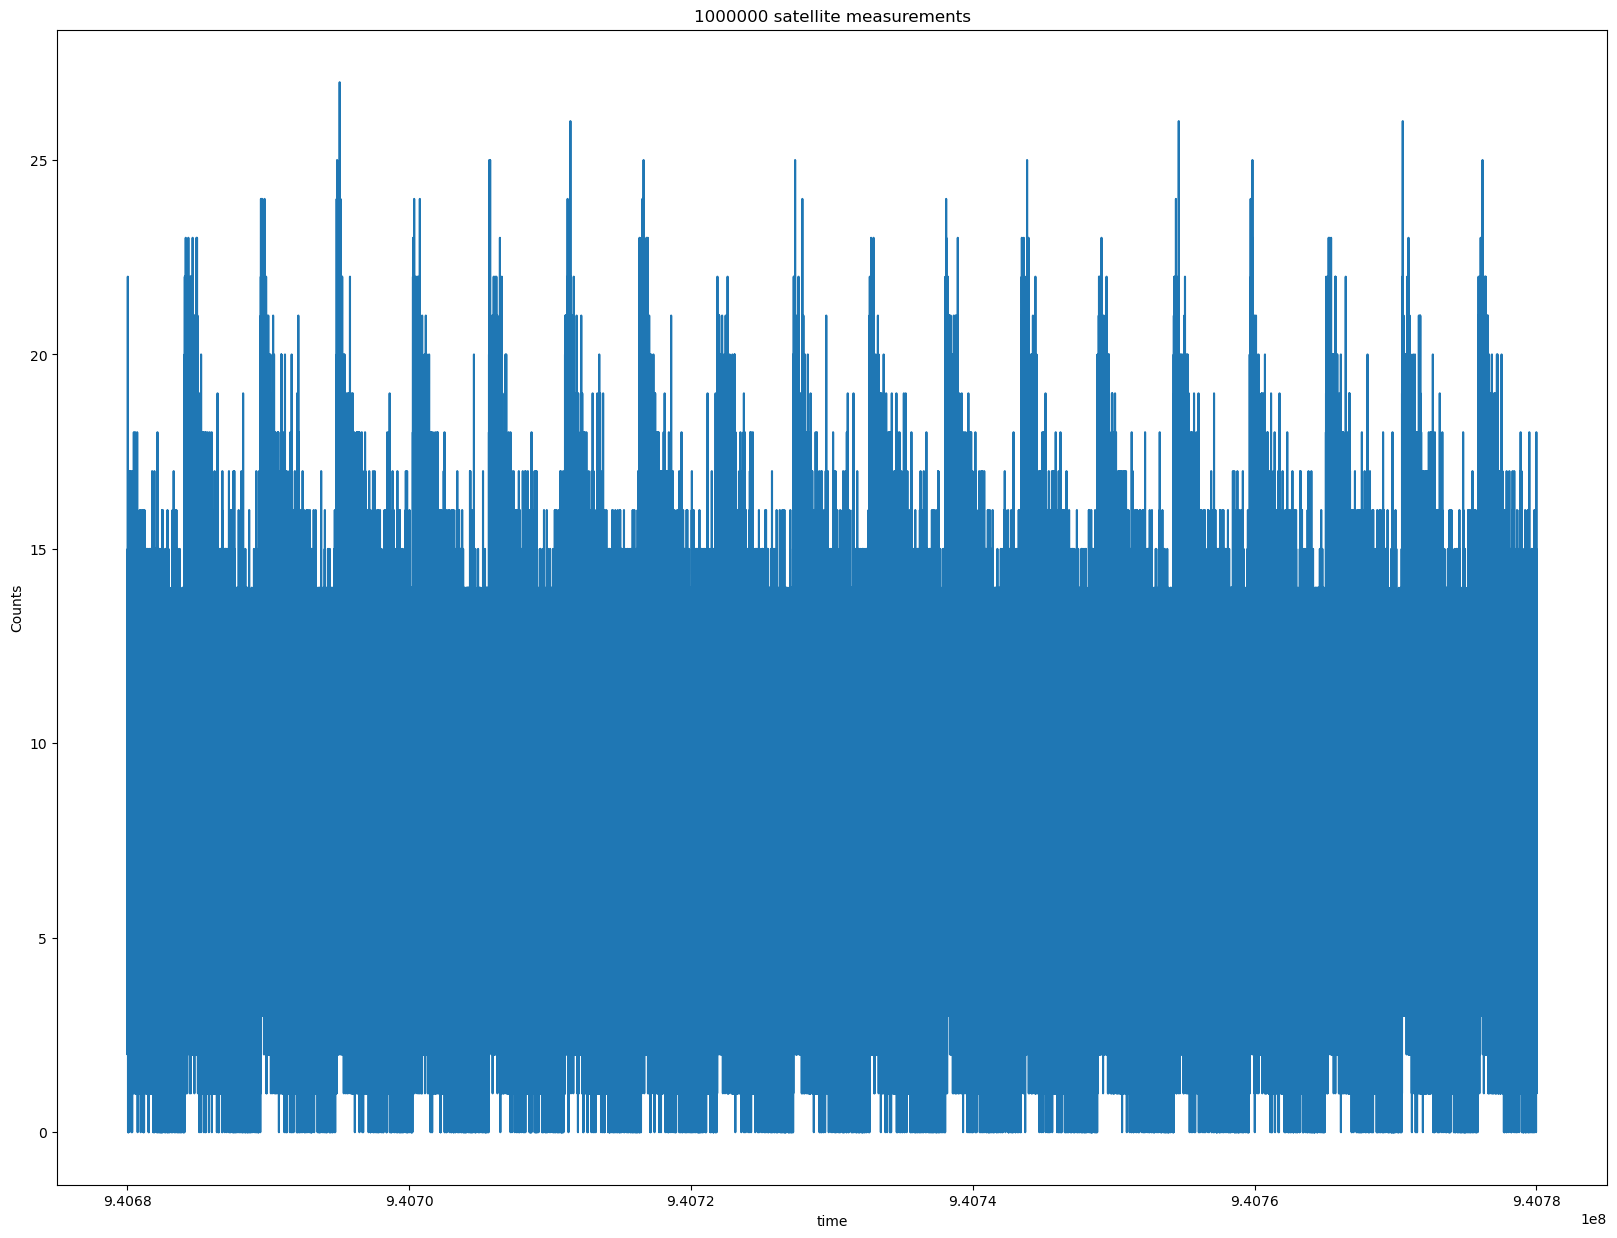

In [6]:
dataPoints = 1000000
plt.plot(data[0][0:dataPoints], data[3][0:dataPoints])
plt.title(f"{dataPoints} satellite measurements")
plt.xlabel("time")
plt.ylabel("Counts")

From the graph above, we can clearly see some kind of pattern, the peaks seems periodic.

Now we plot solar phase and longitude verse time

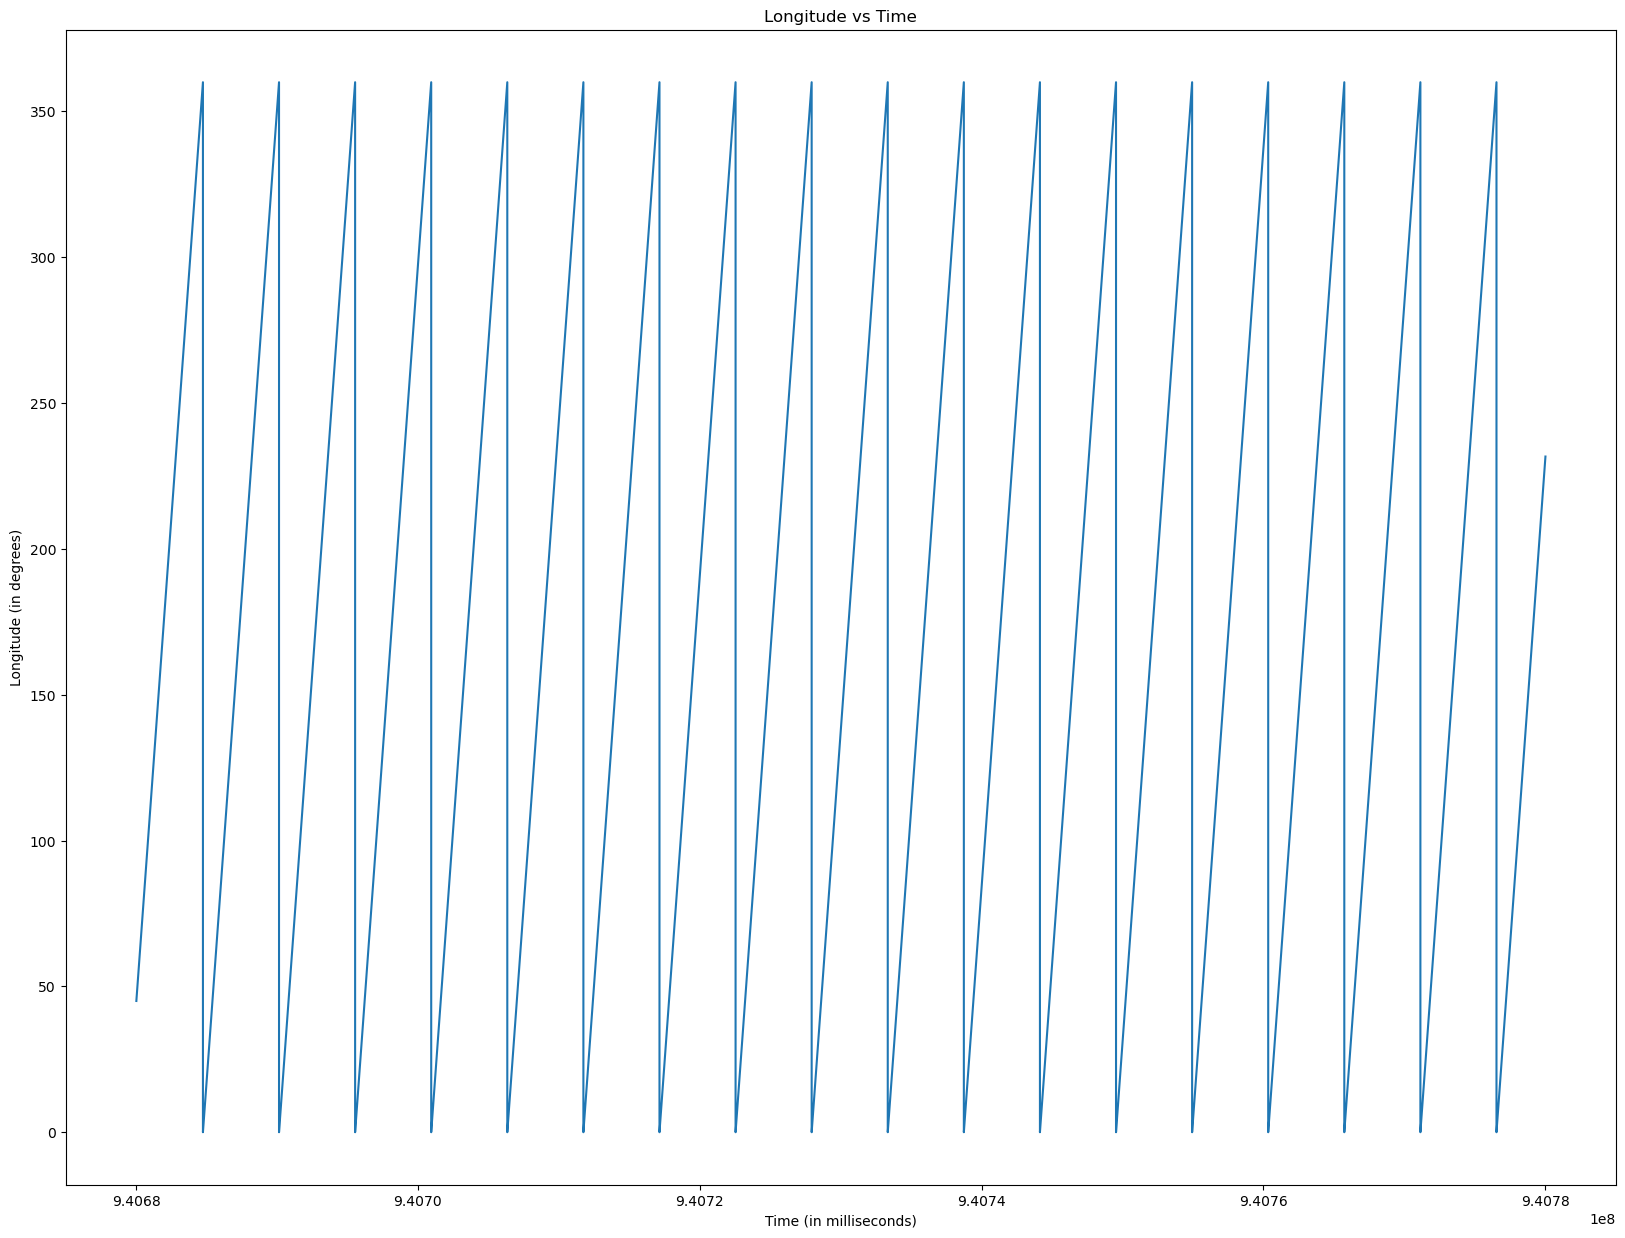

In [10]:
x = data[0, 0:dataPoints]
y = data[2, 0:dataPoints]
plt.plot(x, y)
plt.title('Longitude vs Time')
plt.ylabel('Longitude (in degrees)')
plt.xlabel('Time (in milliseconds)')
plt.show()

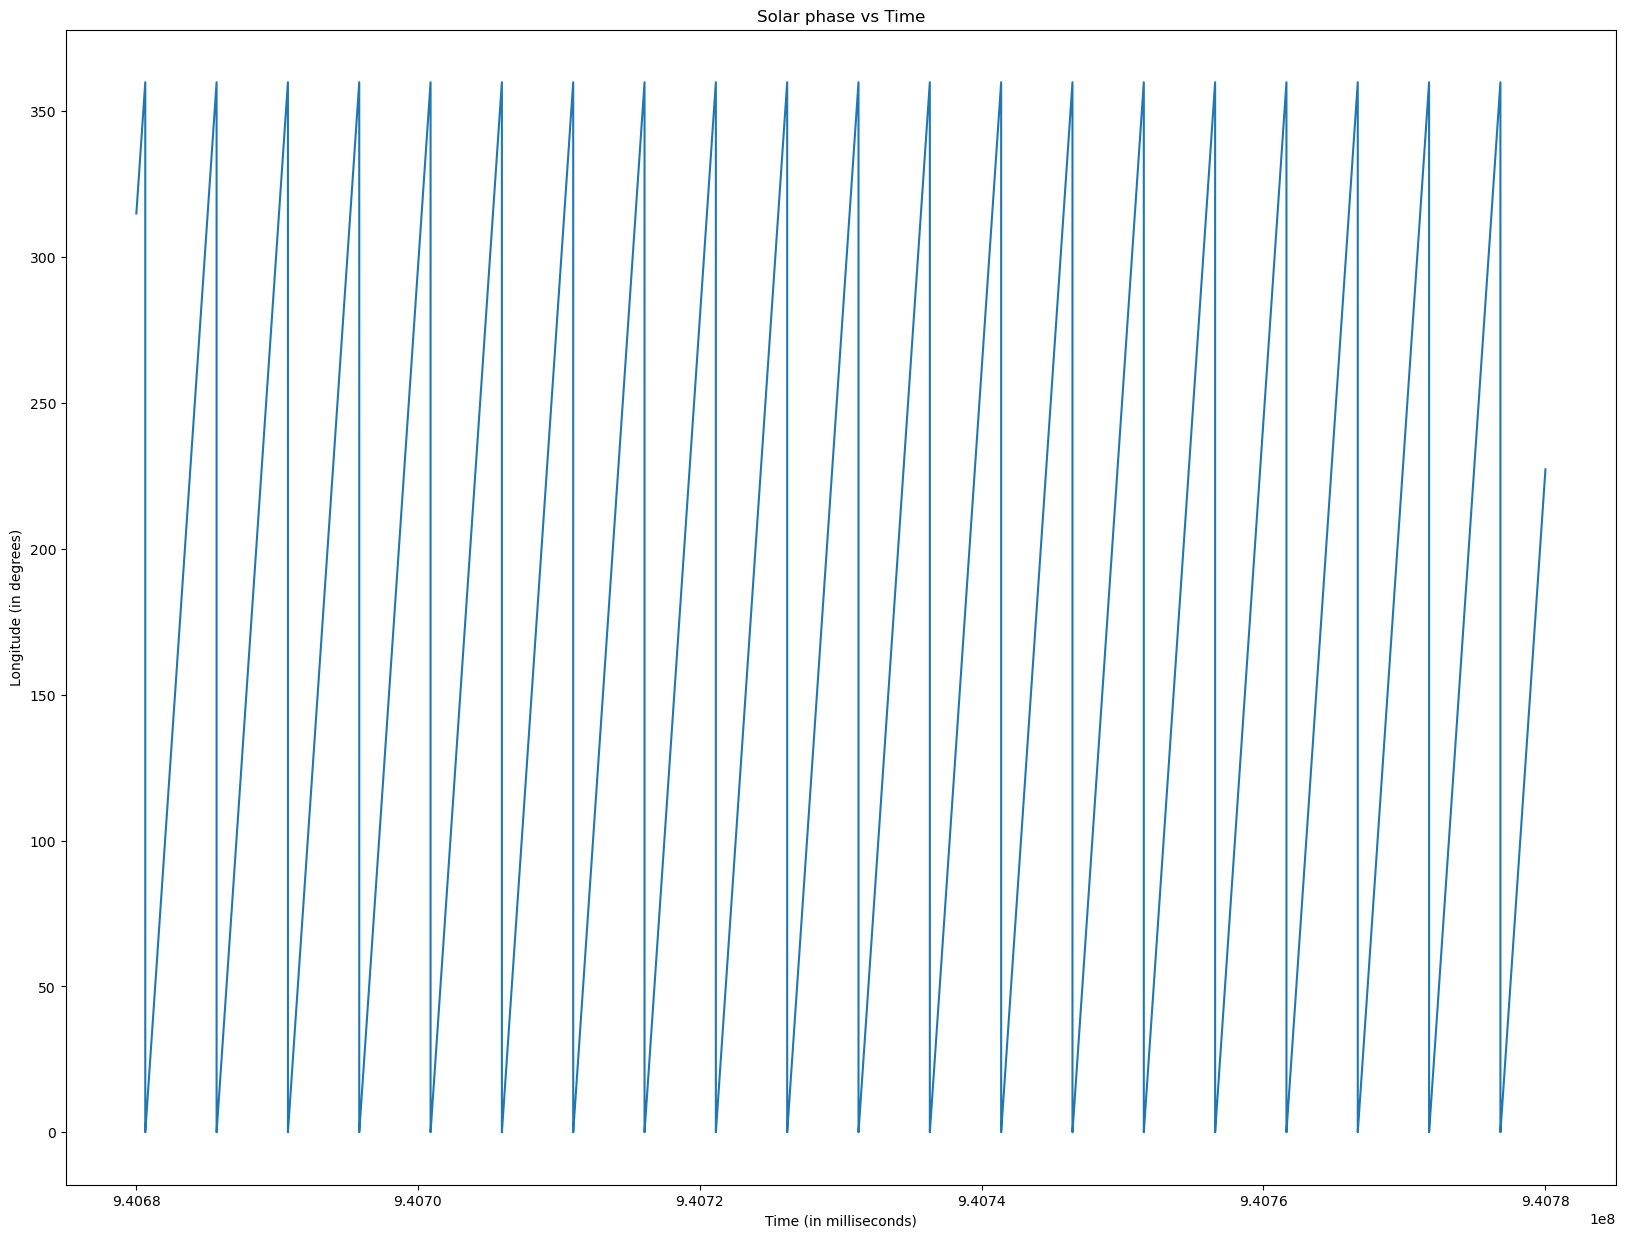

In [13]:
x = data[0, 0:dataPoints]
y = data[1, 0:dataPoints]
plt.plot(x, y)
plt.title('Solar phase vs Time')
plt.ylabel('Longitude (in degrees)')
plt.xlabel('Time (in milliseconds)')
plt.show()

Looking at solar phase and longitude verses time we can tell that the measurement is almost perfectly perodic, which makes sense since the sattlite is just orbiting the earth and the measurement should be the same at each cycle.

Now we look at how the particle count varies with solar phase and longitude:

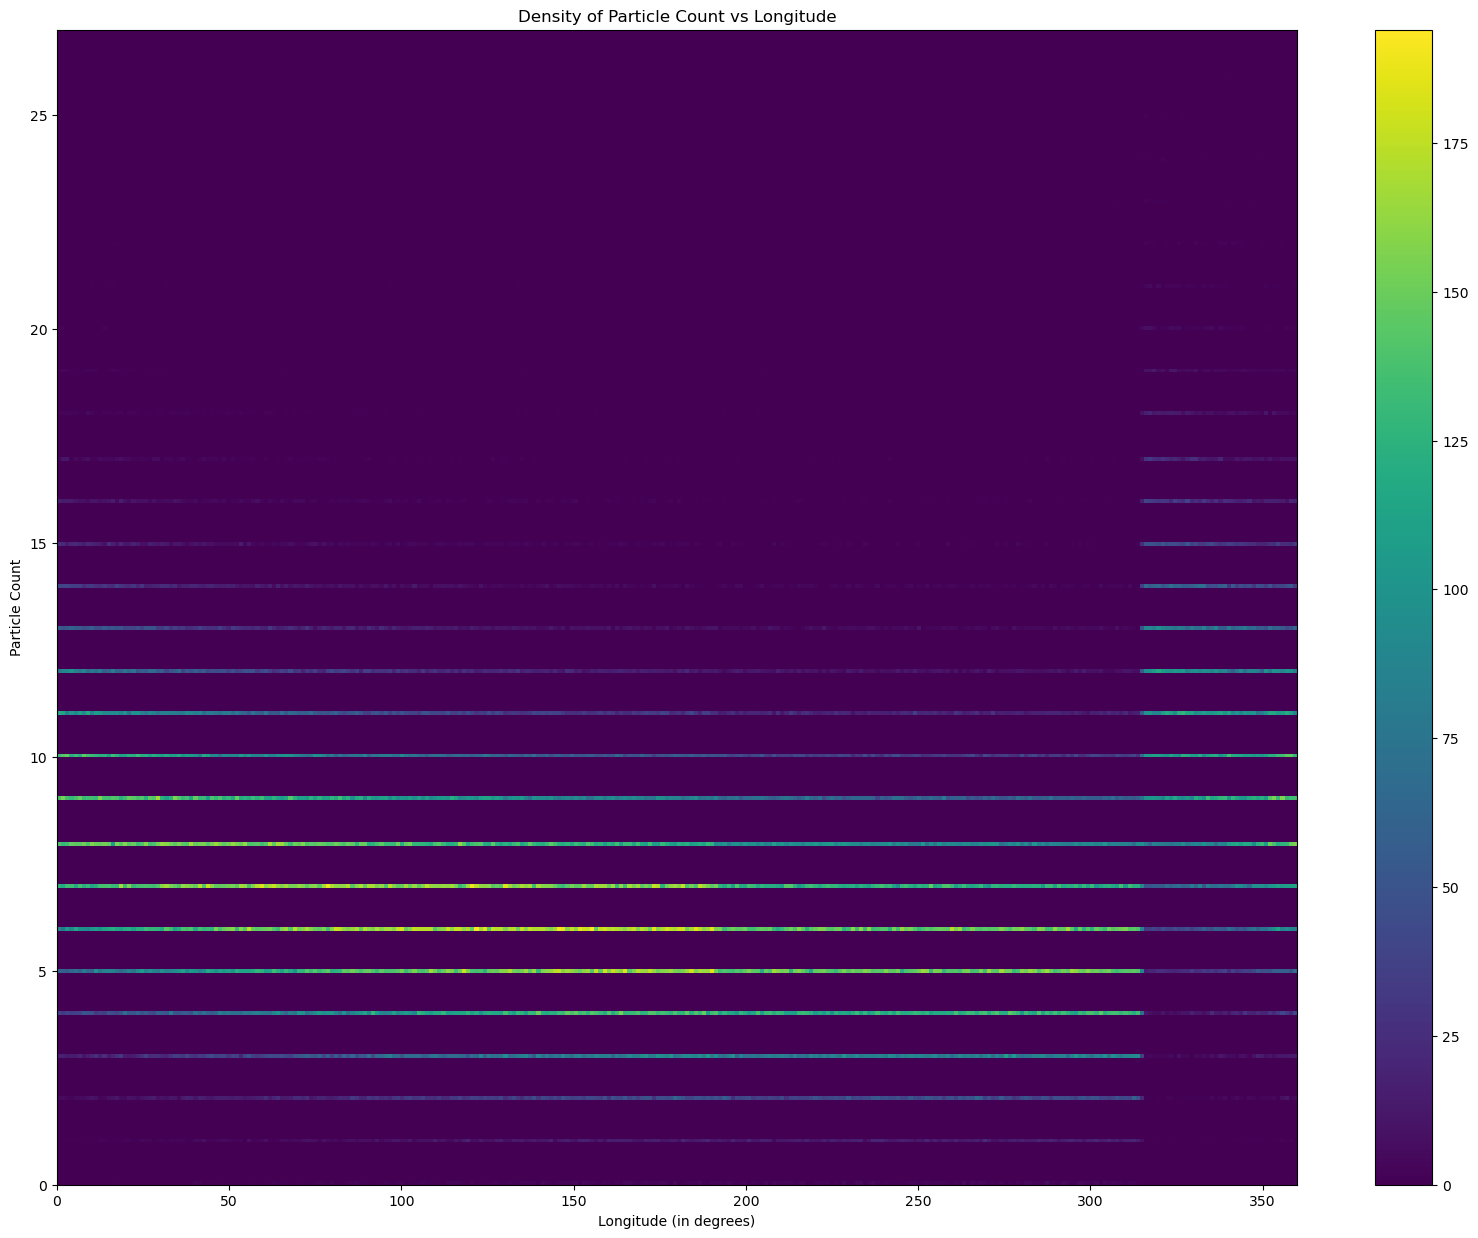

In [20]:
x = data[2, 100000:400000]
y = data[3, 100000:400000]
plt.hist2d(x, y, 300)
plt.title('Density of Particle Count vs Longitude')
plt.xlabel('Longitude (in degrees)')
plt.ylabel('Particle Count')
plt.colorbar()
plt.show()

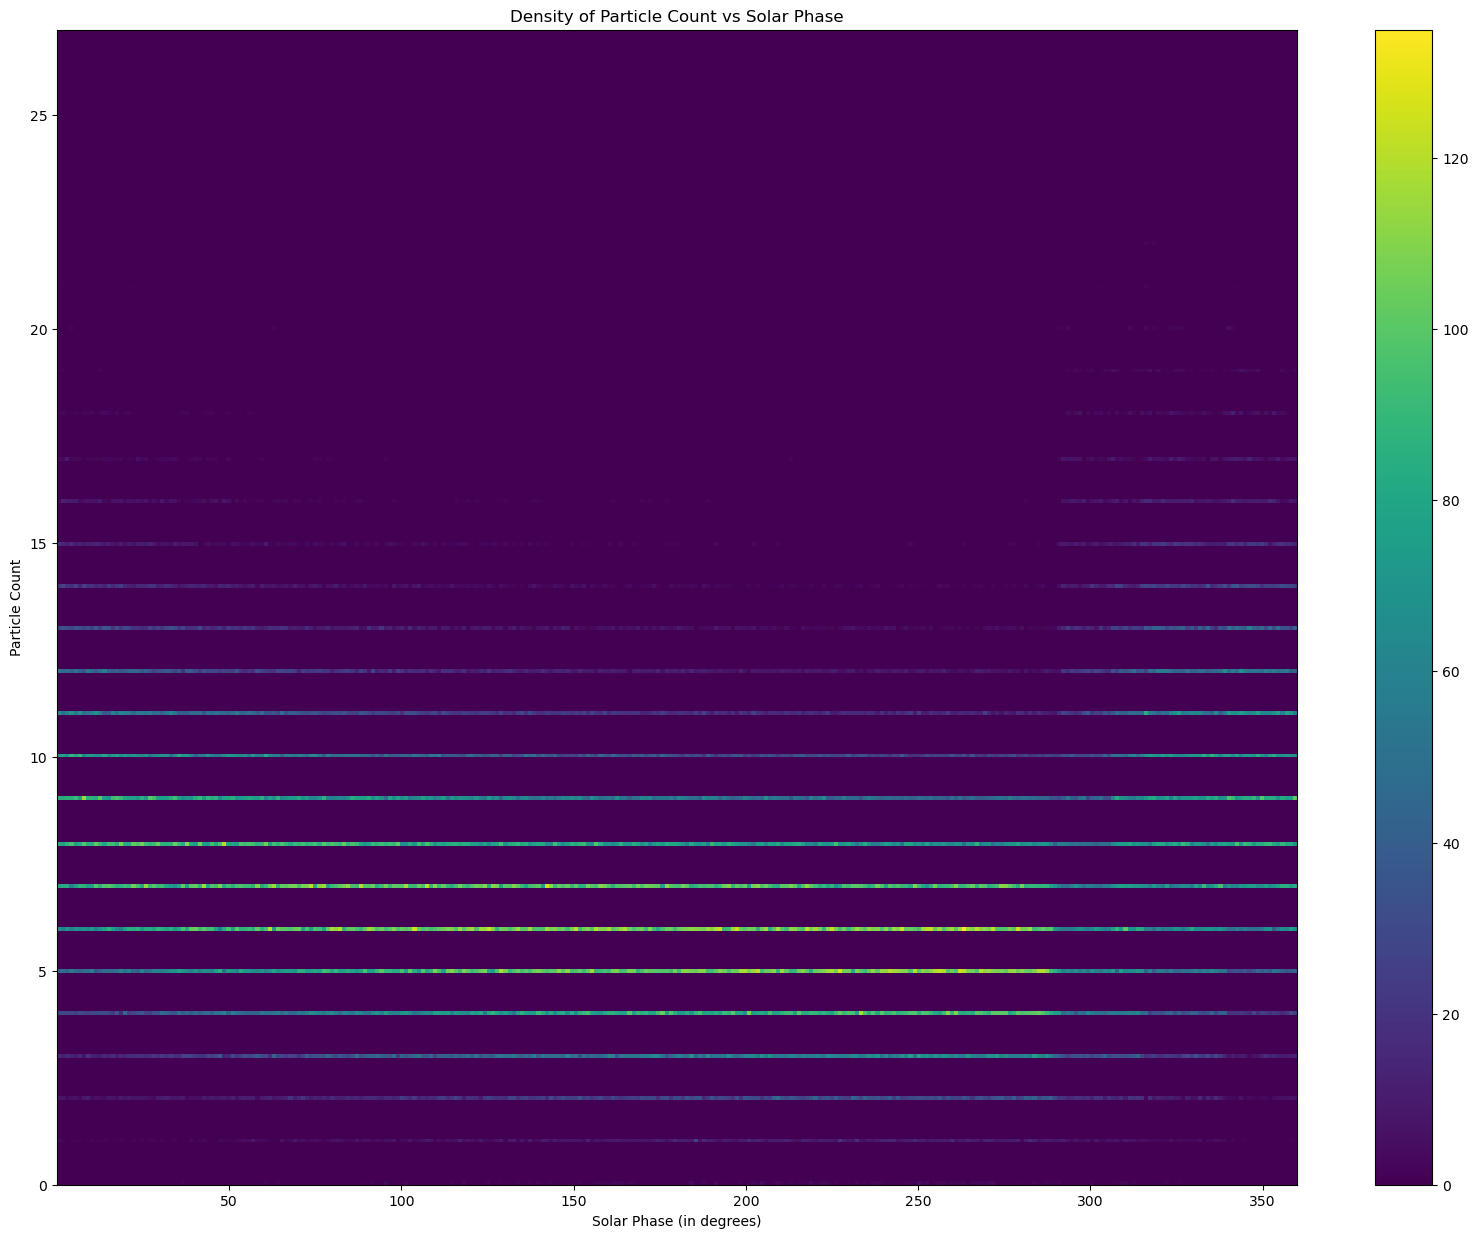

In [18]:
x = data[1, 100000:300000]
y = data[3, 100000:300000]
plt.hist2d(x, y, 300)
plt.title('Density of Particle Count vs Solar Phase')
plt.ylabel('Particle Count')
plt.xlabel('Solar Phase (in degrees)')
plt.colorbar()
plt.show()

From the plots we can see that the mean particle count is around 6 to 9 with longitude around 300-350 degree.

And the background is a Poisson distribution, therefore we can create a poisson distribution with a varying mean, which varies accordingly with how the mean of the background varies with longitude to more accurately describe the background.

To see how the distribution varies according to the longitude, we take the mean of the particle count at each value of that longitude, then make a plot of mean verses longitude:

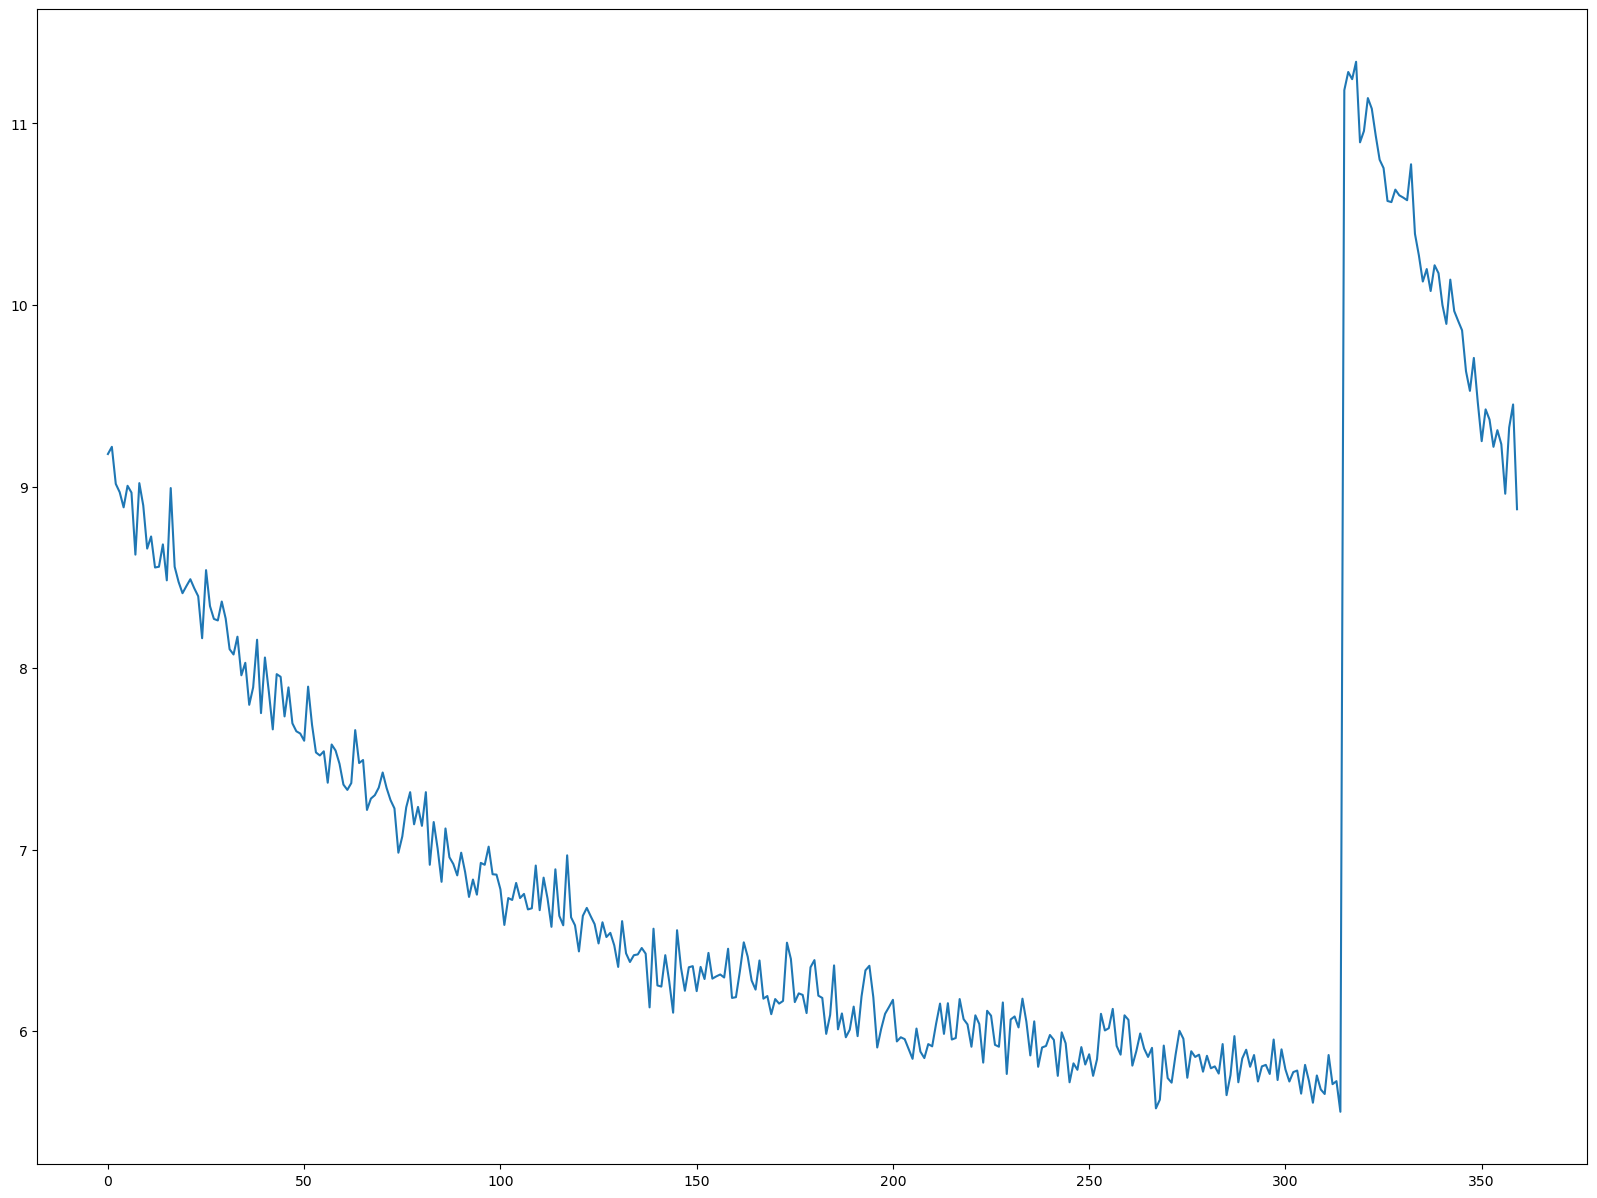

In [24]:
count = data[3]
longitude = np.arange(360)
means = []
for i in longitude:
    mean = np.mean(count[data[2]==i])
    means.append(mean)
plt.plot(longs, means)
plt.show()

We can see there's a big jump from somewhere around 310 degree longitude, so let's find it first.

In [28]:
print("The mean at longitude of 314 degree is " + str(means[314]))
print("The mean at longitude of 315 degree is " + str(means[315]))

The mean at longitude of 314 degree is 5.55625
The mean at longitude of 315 degree is 11.183333333333334


So the big jump is from 314 degree to 315 degree, from mean of 5.56 particles to 11.18 particles. Let's make a time dependent Poisson for the background that would reflect the change in the mean at different longitudes.

This time dependent background distribution is a Poisson distribution with mean equal to the mean particle count at the longitude of the time that will be tested.


In [37]:
def model_plot(time):
    for i in range(len(data[0])):
        if data[0, i] == time:
            long = data[2, i]
            print('Longitude: ' + str(long))
            break
    mean = means[int(long)]
    print('Mean at longitude: ' + str(mean))
    x = np.arange(0,20)
    plt.vlines(x, 0, stats.poisson.pmf(x, mean), colors='b', lw=40, alpha=0.5)
    plt.title('Piosson Distribution, mean = ' + str(mean))
    plt.xlabel('Particle Count')
    plt.xlim(0, 20)
    plt.ylabel('Probability')
    plt.show()

Let's choose some random data points to test if the distribution matches real data.

Longitude: 225.0
Mean at longitude: 6.085416666666666


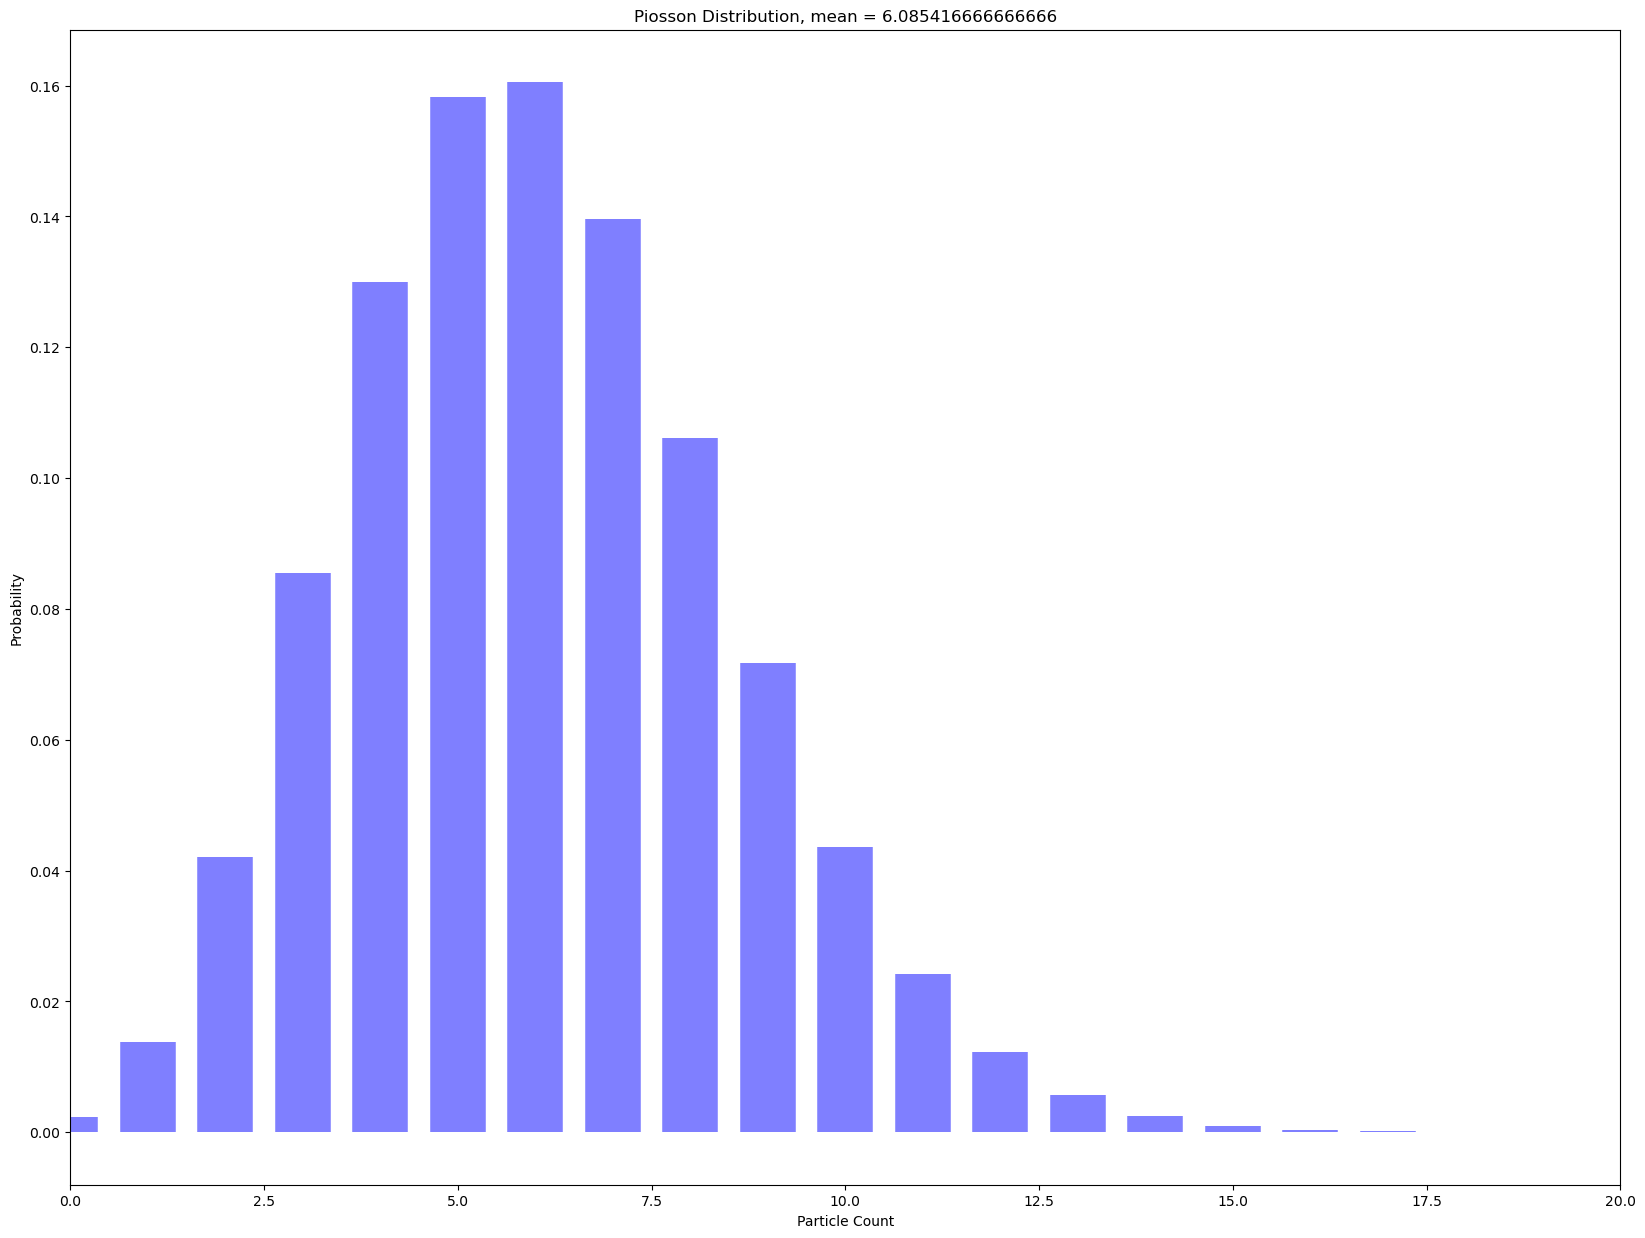

In [41]:
model_plot(data[0,81000])


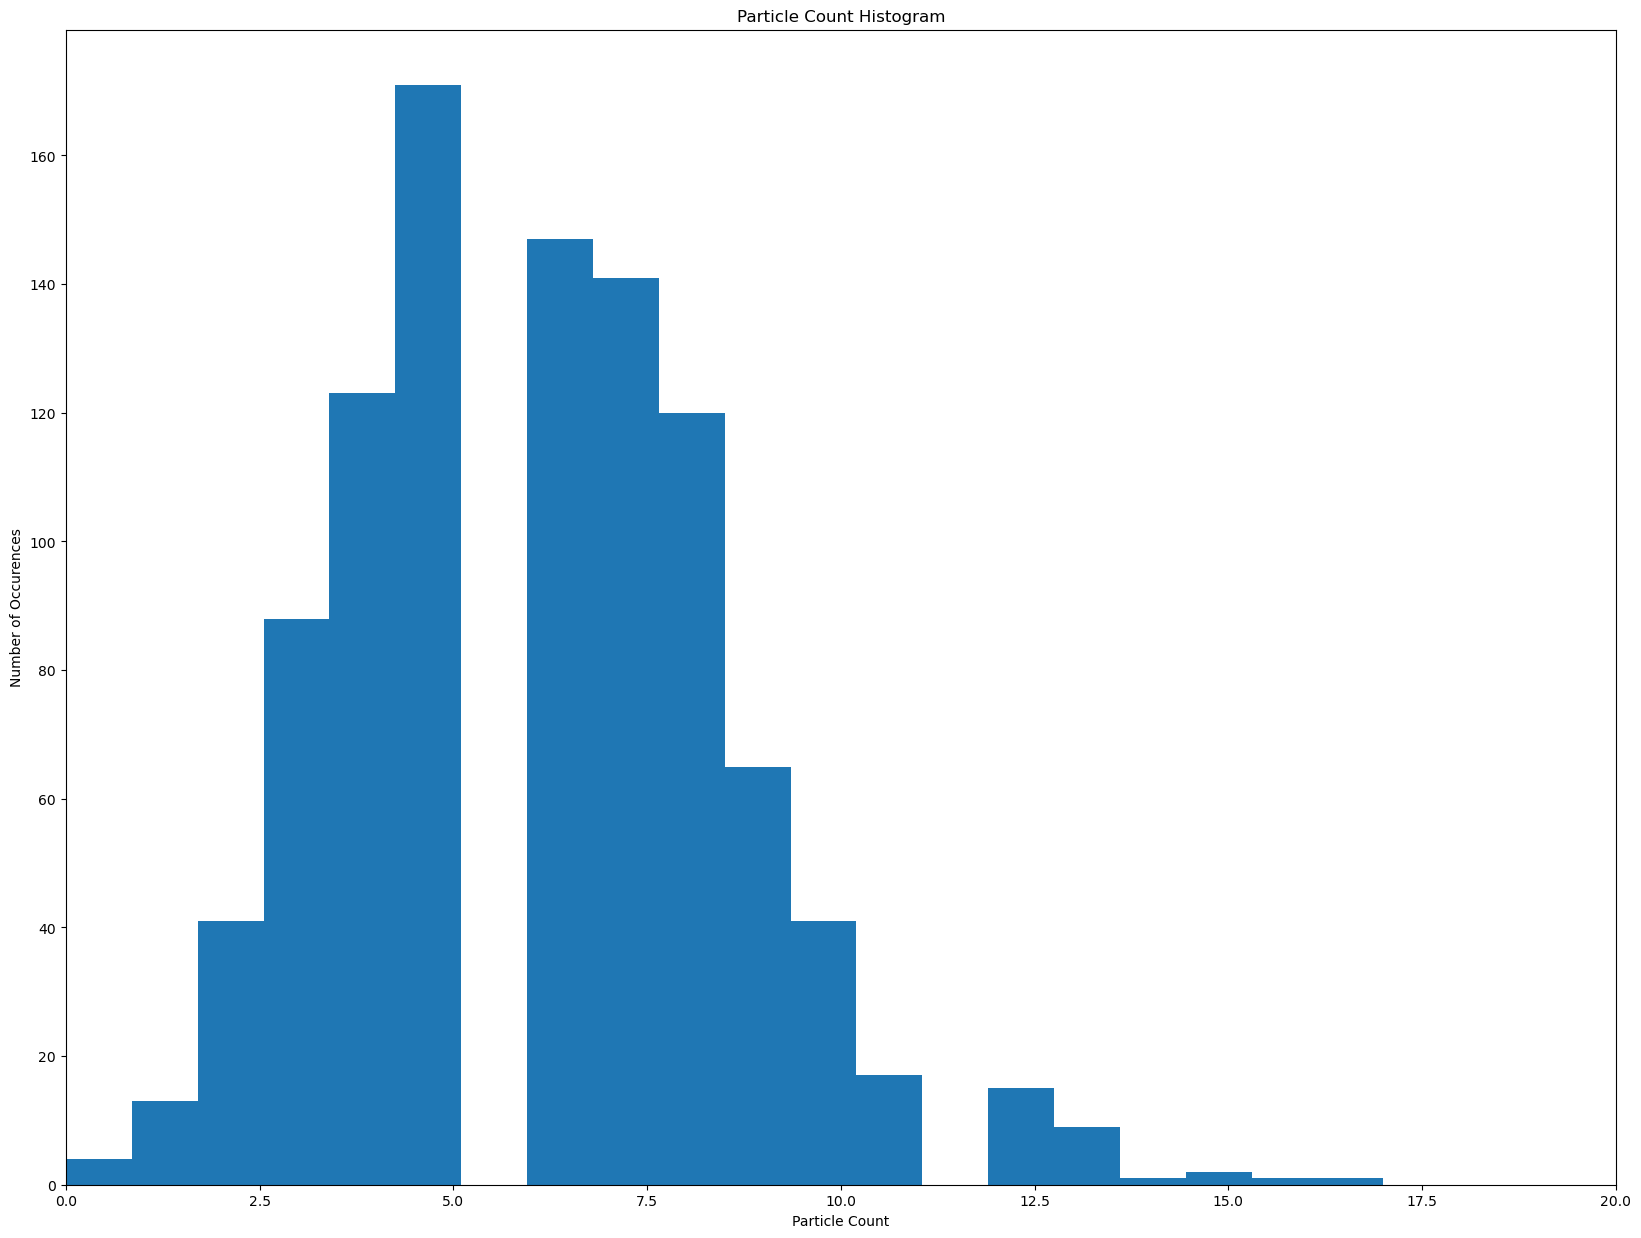

In [42]:
y = data[3,80000:81000]
plt.hist(y, 20)
plt.xlim(0, 20)
plt.title('Particle Count Histogram')
plt.xlabel('Particle Count')
plt.ylabel('Number of Occurences')
plt.show()

Comparing one more set of data:

Longitude: 298.33333333333326
Mean at longitude: 5.73125


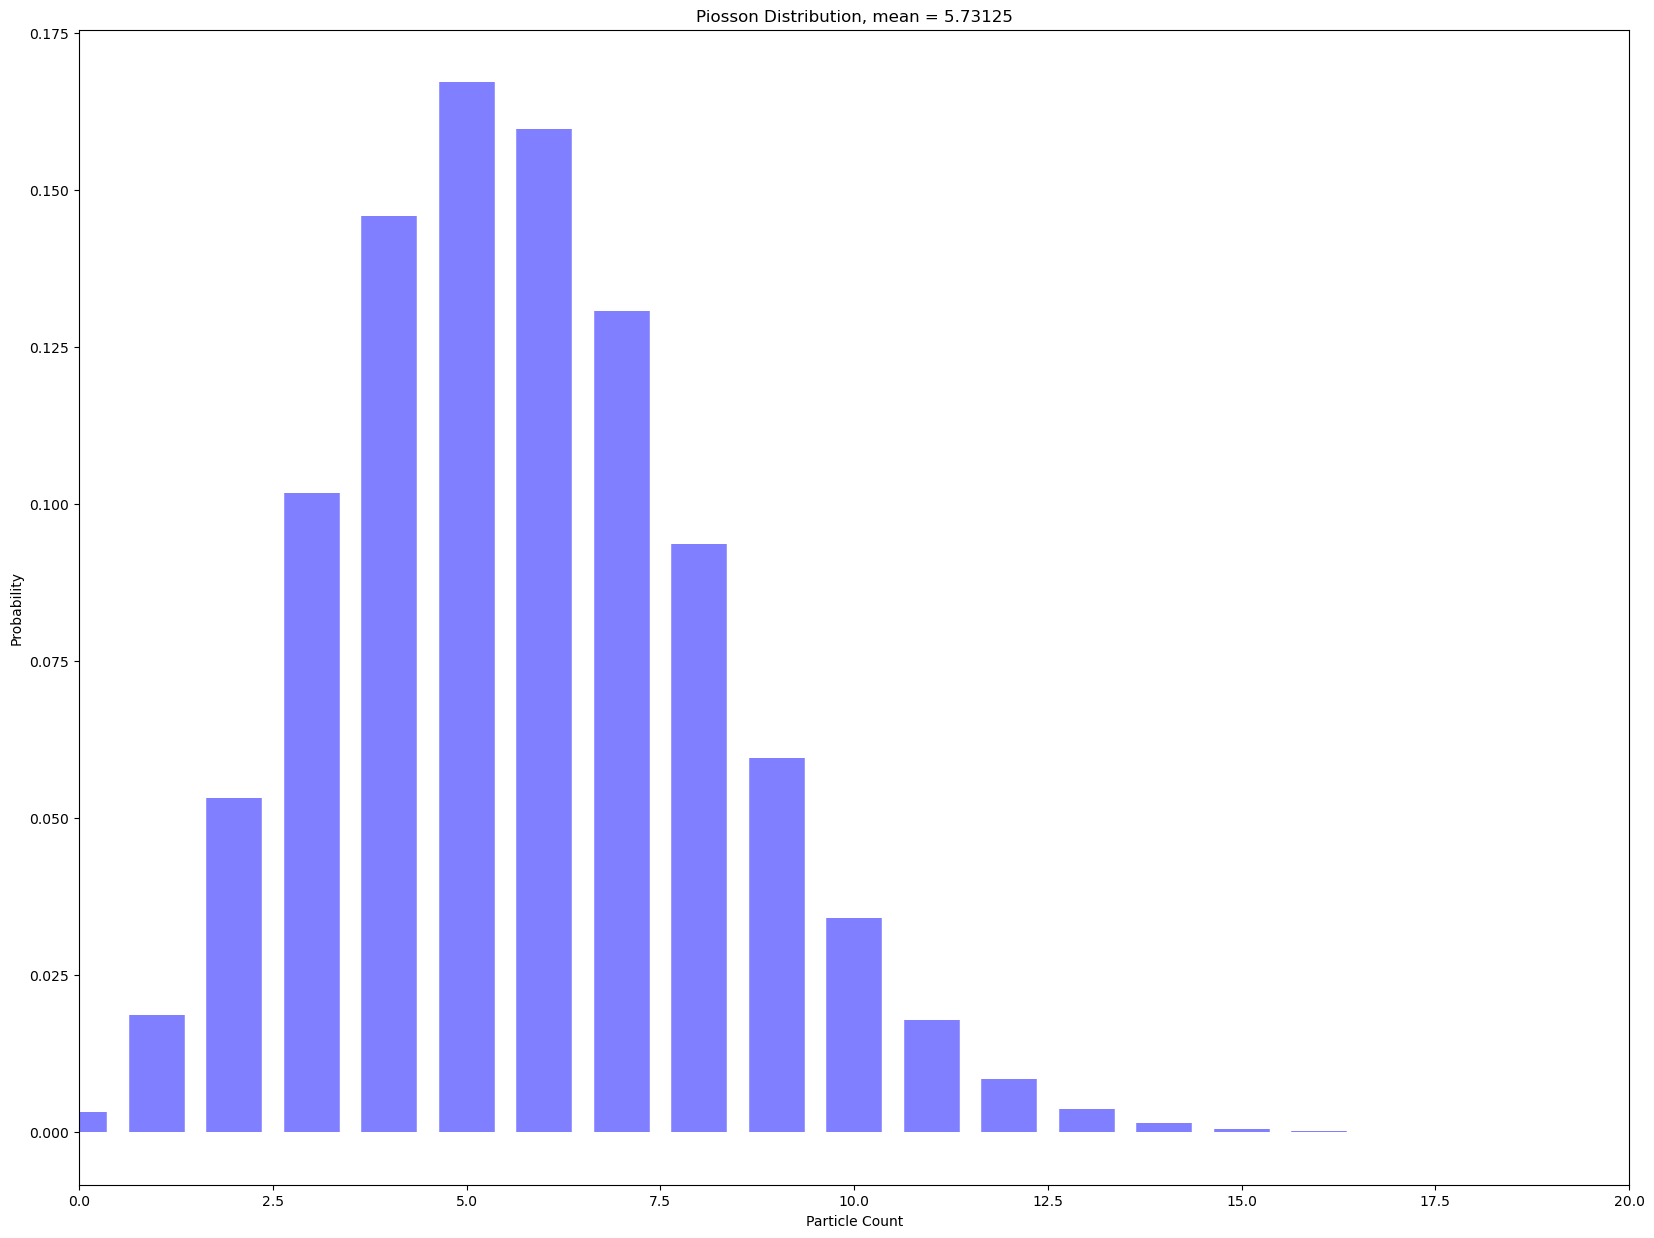

In [48]:
model_plot(data[0,200000])

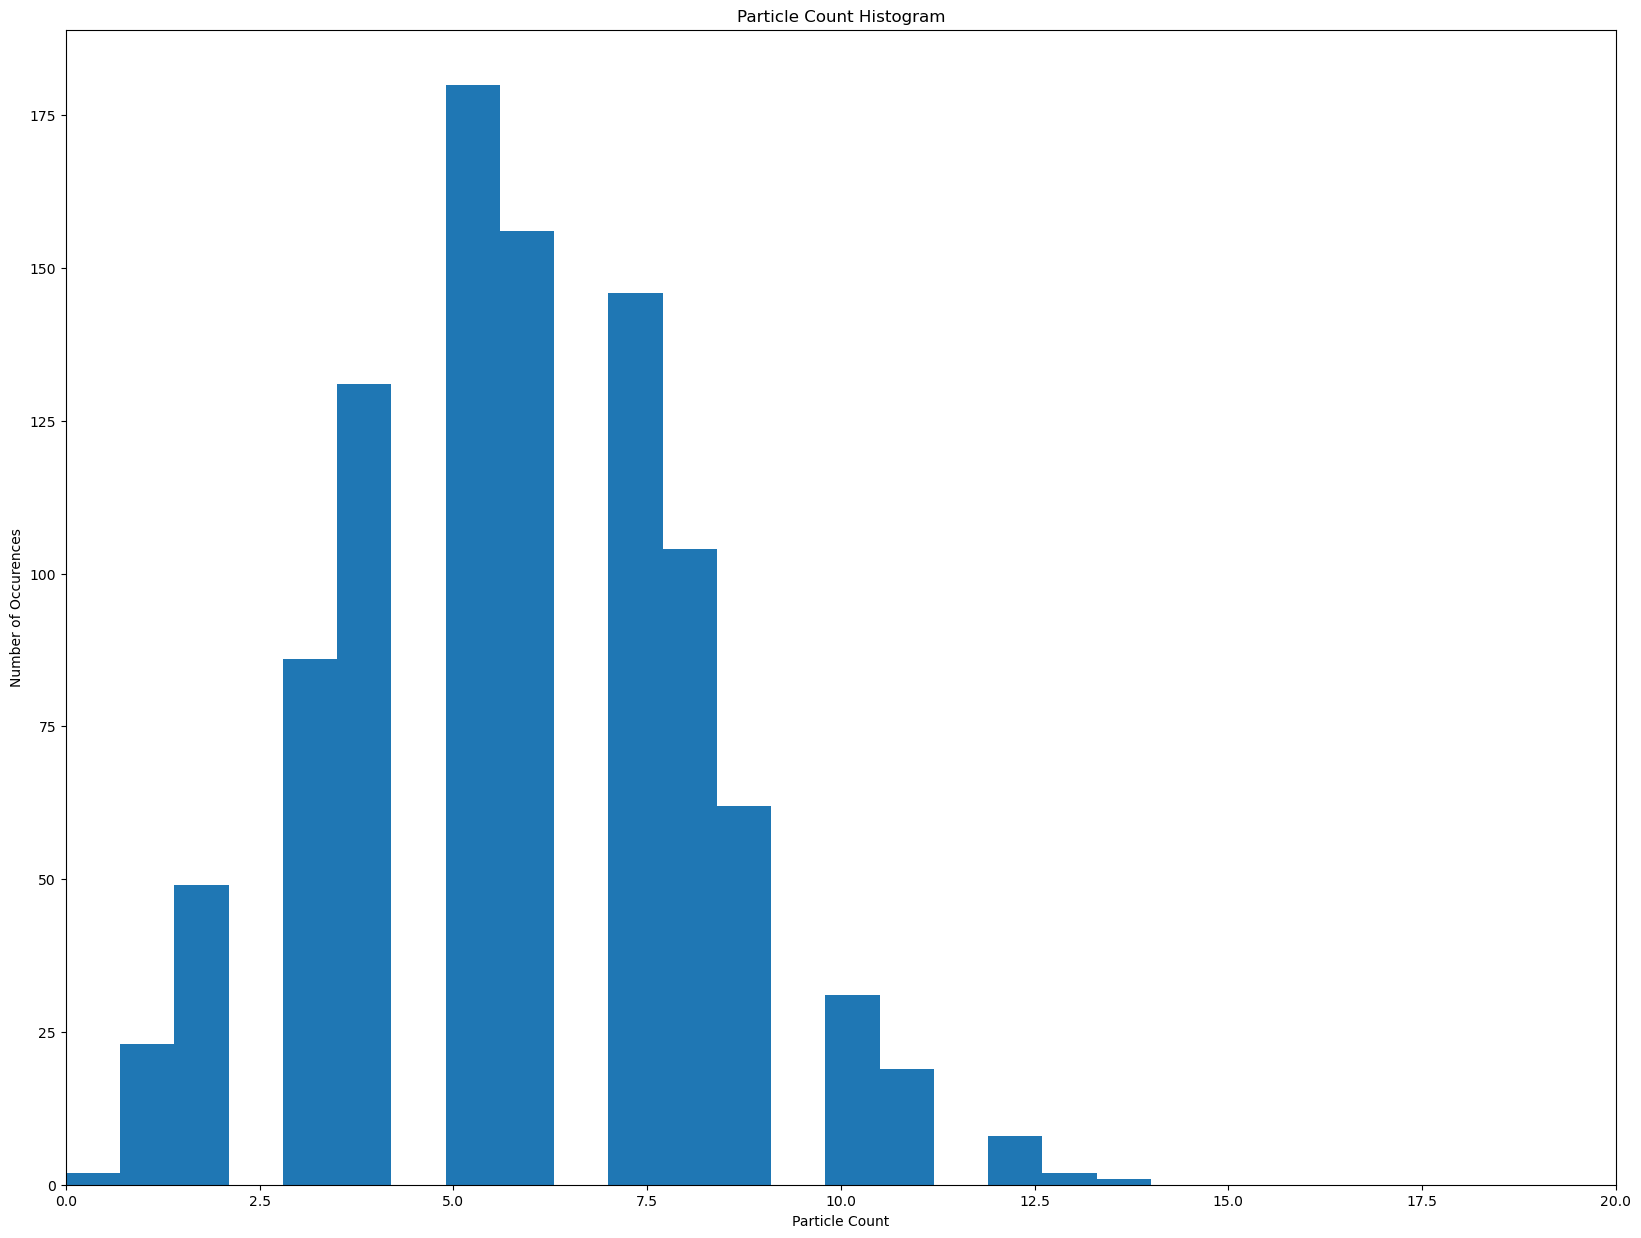

In [47]:
y = data[3,199000:200000]
plt.hist(y, 20)
plt.xlim(0, 20)
plt.title('Particle Count Histogram')
plt.xlabel('Particle Count')
plt.ylabel('Number of Occurences')
plt.show()

Comparing the outcomes of the model to the real data, we can say the model falls pretty well with the distribution of the particles.

Now we make a function which will calculate the 5$\sigma$ threshold at given time

In [51]:
def func(time, threshold):
    for i in range(len(data[0])):
        if data[0, i] == time:
            long = data[2, i]
            break
    mean = means[int(long)]
    prob = 1 - stats.norm.cdf(threshold)
    threshold = stats.poisson.ppf(1 - prob, mean)
    print('Time chosen: ' + str(time))
    print('Longitude: ' + str(long))
    print('Mean at longitude: ' + str(mean))
    print('Threshold for 5 sigma: ' + str(threshold))

In [52]:
func(data[0,81000],5)

Time chosen: 940688116.0
Longitude: 225.0
Mean at longitude: 6.085416666666666
Threshold for 5 sigma: 22.0


In [53]:
func(data[0,200000],5)

Time chosen: 940700016.0
Longitude: 298.33333333333326
Mean at longitude: 5.73125
Threshold for 5 sigma: 21.0


Let's do one more data point:

In [56]:
func(data[0,99900],5)

Time chosen: 940690006.0
Longitude: 351.0
Mean at longitude: 9.425
Threshold for 5 sigma: 28.0


Therefore the according 5$\sigma$ threshold for the three time chosen above is 22,21 and 28 respectively.

# Problem 2
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

In [75]:
hf5 = h5py.File('images.h5', 'r')
hf5.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

first we explore the data

In [86]:
with h5py.File('images.h5','r') as f:
    data=f['imagestack'][()]
    data1 = f['image1'][()]

now we plot the image stack, which has 10 images total.

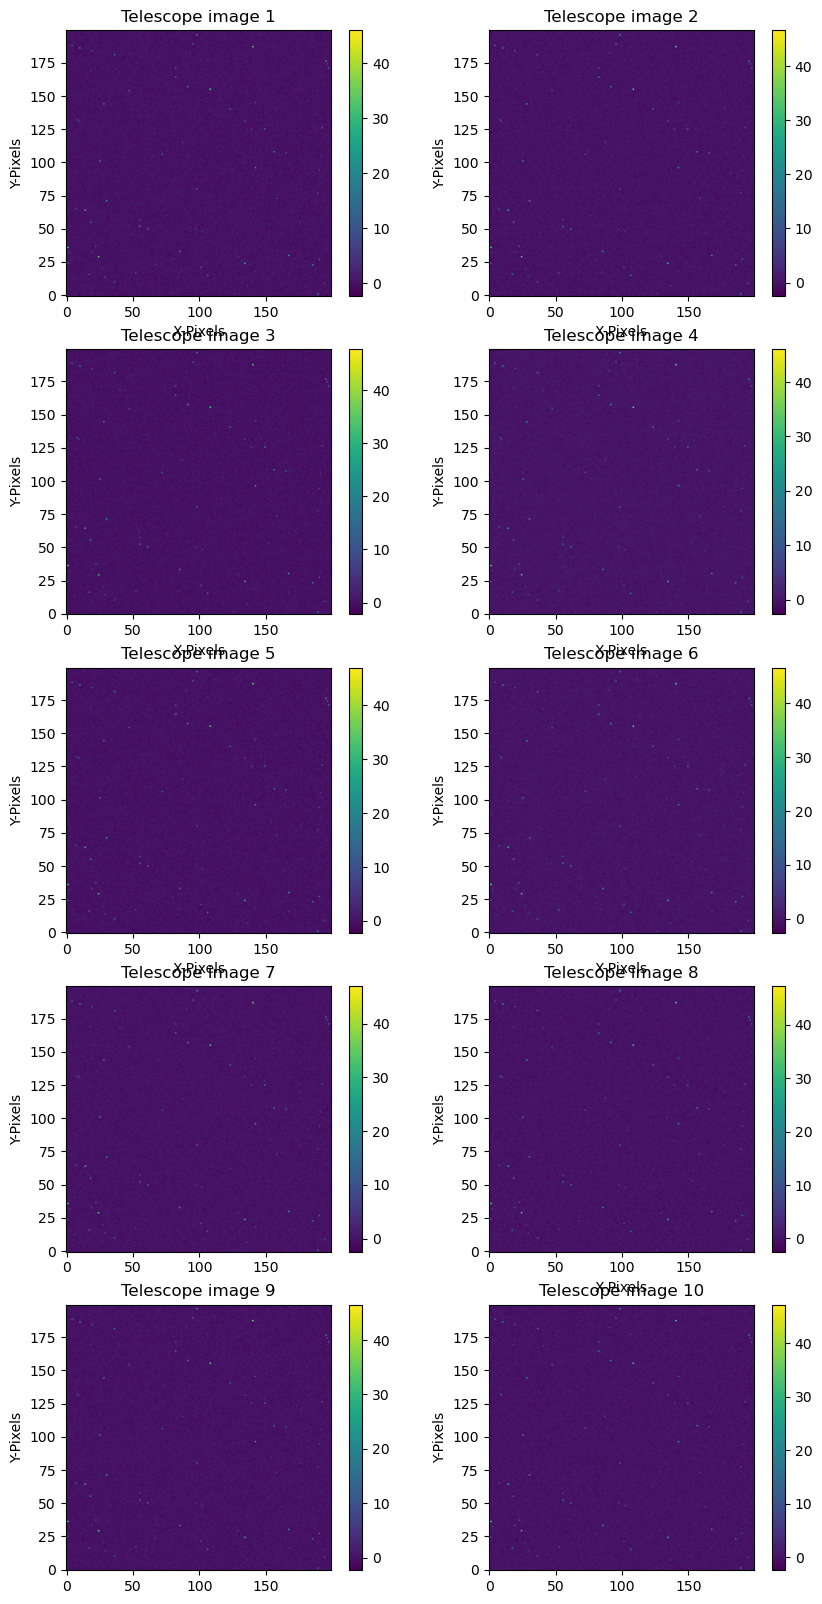

In [89]:
plt.rcParams["figure.figsize"] = (10,20)
fig,ax=plt.subplots(5,2)
for i in range(data.shape[2]):
    img = ax[i//2,i%2].imshow(data[:,:,i], origin='lower')
    ax[i//2,i%2].title.set_text('Telescope image %s'%(i+1))
    ax[i//3,i%2].set_xlabel('X-Pixels')
    ax[i//2,i%2].set_ylabel('Y-Pixels')
    fig.colorbar(img, ax=ax[i//2,i%2])
plt.show()

The colorbar is still the same as the first graph, which is the lowest at violet and highest at yellow.

Comparing these 10 graphs, we find them very similar. Since supernovae are ephemeral, we will take subtraction between the nearest two images and expect a significant difference, either positive or negative.

In [90]:
img_diff = []
for i in range(9):
    img_diff.append(data[:,:,i]-data[:,:,i+1])

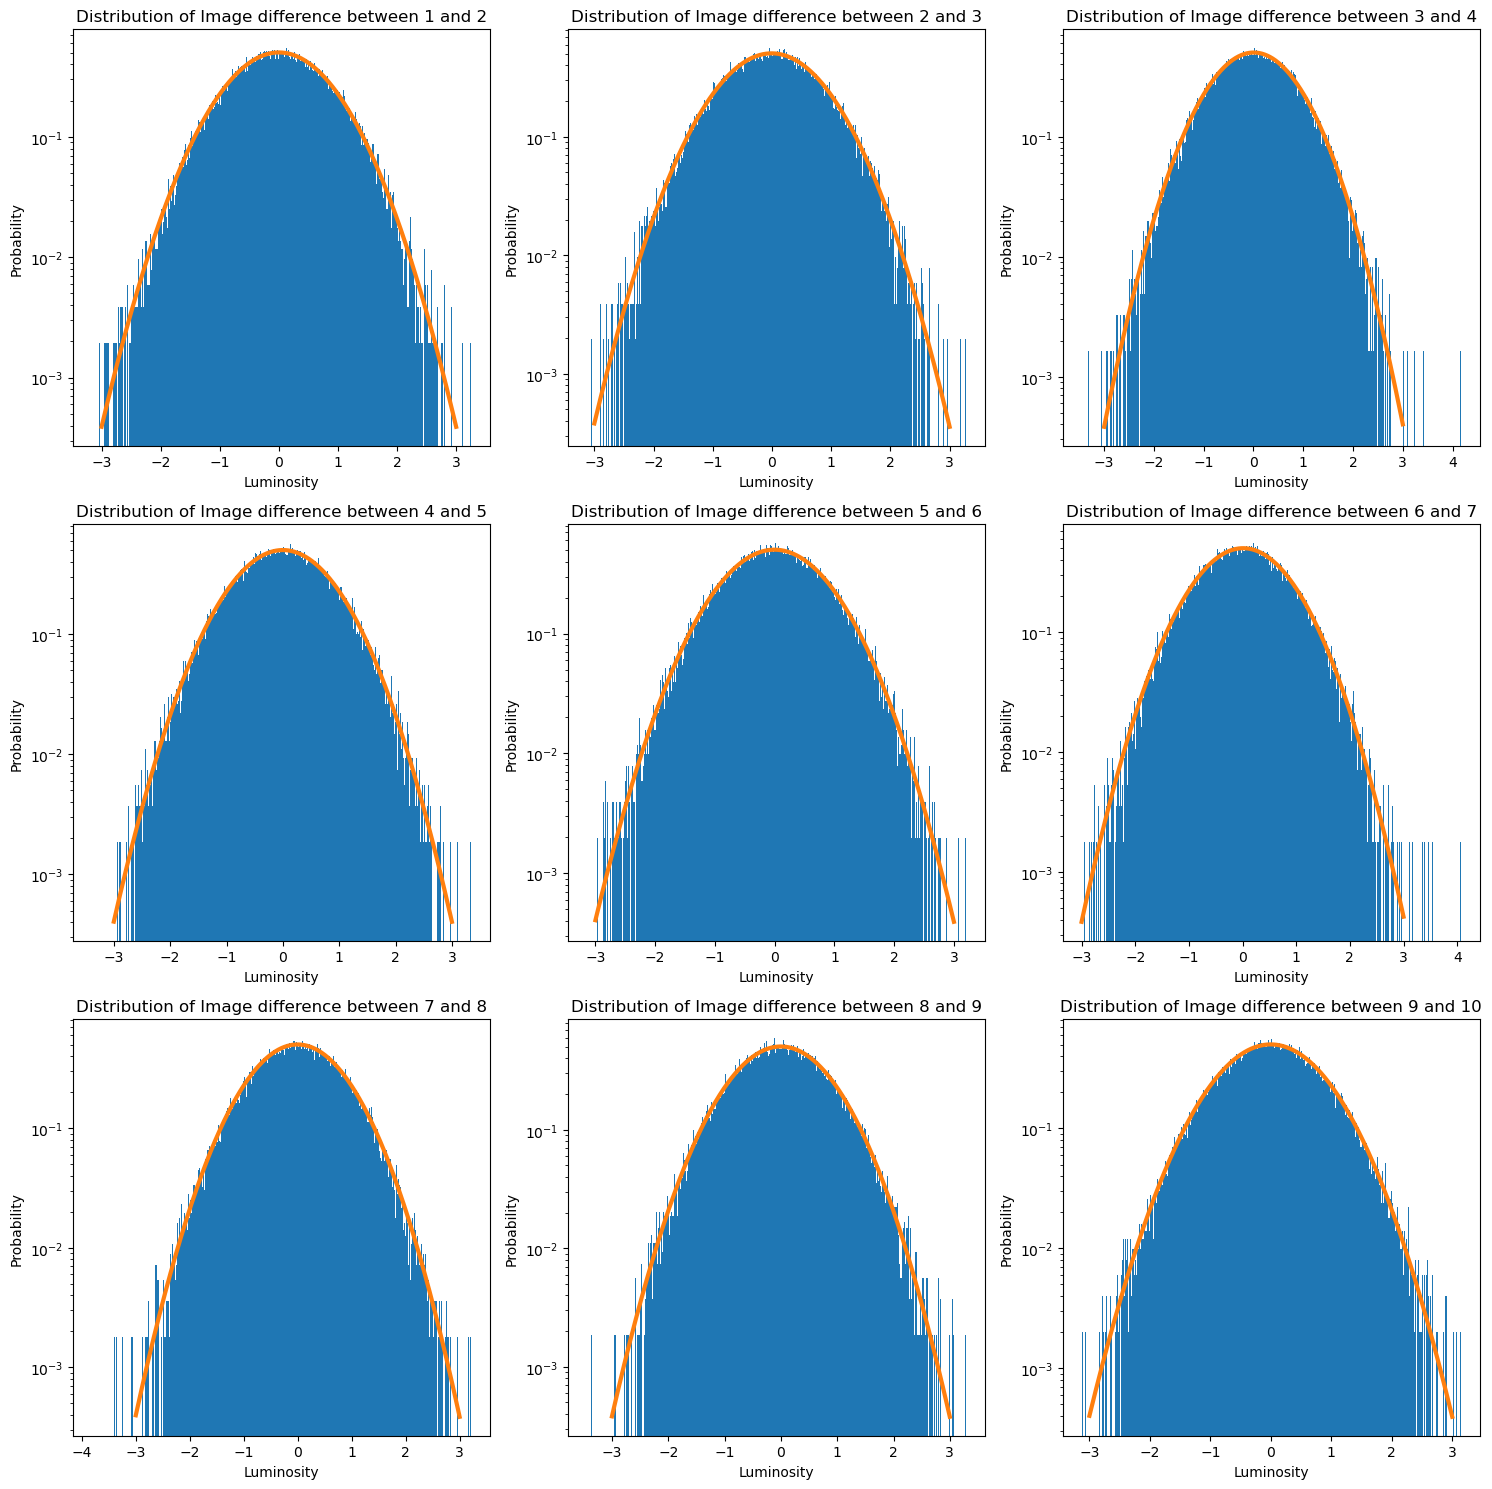

In [92]:
means = np.mean(img_diff,axis=(1,2))
stds = np.std(img_diff,axis=(1,2))
xrange = np.arange(-3,3,1e-3)

plt.rcParams["figure.figsize"]
fig,ax=plt.subplots(3,3)
for i, img in enumerate(img_diff):
    ax[i//3,i%3].hist(img.flatten(),500,density=True)
    ax[i//3,i%3].plot(xrange,stats.norm.pdf(xrange,means[i],stds[i]),linewidth=3)
    ax[i//3,i%3].title.set_text('Distribution of Image difference between %s and %s'%((i+1),(i+2)))
    ax[i//3,i%3].set_xlabel('Luminosity')
    ax[i//3,i%3].set_ylabel('Probability')
    ax[i//3,i%3].set_yscale('log')
plt.tight_layout()
plt.show()


These are the backgrounds, we can see that they are mostly gaussian distributions, only different in minor details.

Next we check whether the mean and SD changes as times changes.

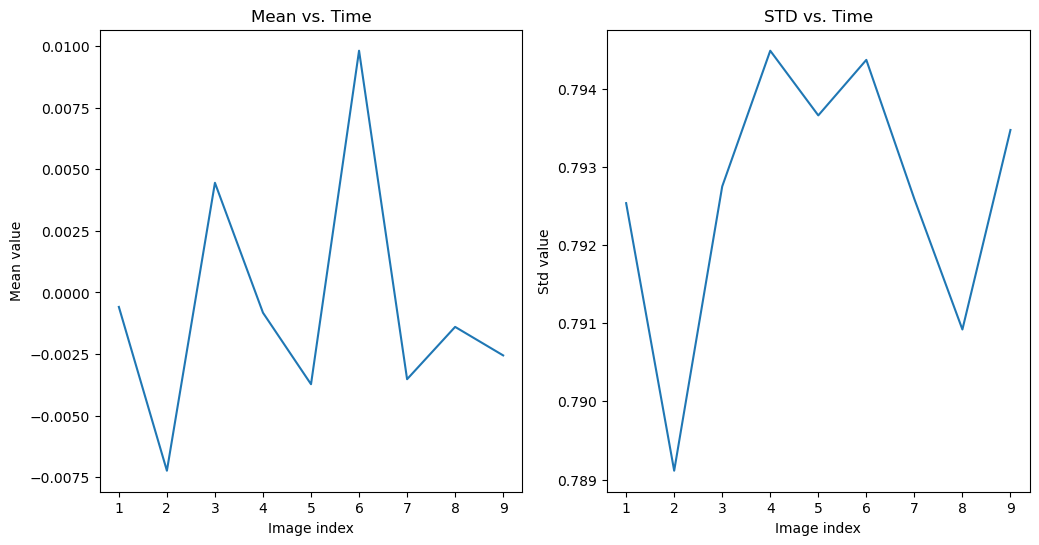

In [93]:
plt.rcParams["figure.figsize"] = (12,6)
fig,ax = plt.subplots(1,2)
ax[0].title.set_text("Mean vs. Time")
ax[0].plot(np.arange(1,10,1),means)
ax[0].set_xlabel("Image index")
ax[0].set_ylabel("Mean value")
ax[1].title.set_text("STD vs. Time")
ax[1].set_xlabel("Image index")
ax[1].set_ylabel("Std value")
ax[1].plot(np.arange(1,10,1),stds)
plt.show()

And we see that mean and SD changes as time changes, therefore the background is time dependent.

In [96]:
def compare_x_signals(data,ind1,ind2,x):
    img1 = data[:,:,ind1]
    img2 = data[:,:,ind2]
    signal1 = np.sort(img1.flatten())[-x:]
    signal2 = np.sort(img2.flatten())[-x:]
    sig1_ind = []
    sig2_ind = []
    for sig in signal1:
        i, j = np.where(img1 == sig)
        sig1_ind.append((int(i),int(j)))
    for sig in signal2:
        i, j = np.where(img2 == sig)
        sig2_ind.append((int(i),int(j)))
    if set(sig1_ind)==set(sig2_ind) :
        return True
    else:
        return [sig1_ind,sig2_ind]

In [97]:
result=[]
for i in range(1,10):
    result.append(compare_x_signals(data,0,i,10))
result

[True, True, True, True, True, True, True, True, True]

Intuitively speaking, the movement of the planet should be trivial in 10 seconds. We can assume that the background in the telescope image is not moving. Let's compare the positions of the top 10 brightest stars to explain further.

The results show that the ten brightest stars are aligned at the same location in the ten pictures. Although it is not very convincing to compare only the ten brightest stars, the brightness of the stars will change, and we don't have a any method to track a specific star, so just use this way to prove it simply - the spatial consistency of the background.


3) To find supernovae, we need to find the 5 sigma of each background. Then we find the points that's above that

In [98]:
five_sigma =[]
for i in range(9):
    five_sigma.append(stats.norm.isf(stats.norm.sf(5),means[i],stds[i]))

In [ ]:
plt.rcParams["figure.figsize"]
fig,ax=plt.subplots(3,3)
for i, img in enumerate(img_diff):
    pic = ax[i//3,i%3].imshow(img*(abs(img)>five_sigma[i]))
    ax[i//3,i%3].title.set_text('Image difference between %s and %s'%((i+1),(i+2)))
    ax[i//3,i%3].set_xlabel('X-Pixels')
    ax[i//3,i%3].set_ylabel('Y-Pixels')
    fig.colorbar(pic, ax=ax[i//3,i%3])
plt.tight_layout()
plt.show()

In [100]:
print(np.where(abs(img_diff[2]) > five_sigma[2]))
print(np.where(abs(img_diff[5]) > five_sigma[5]))

(array([51]), array([148]))
(array([9]), array([153]))


So these two points exceeds 5 sigma, which is in the 3rd and 6th graph, let's find them and plot them.

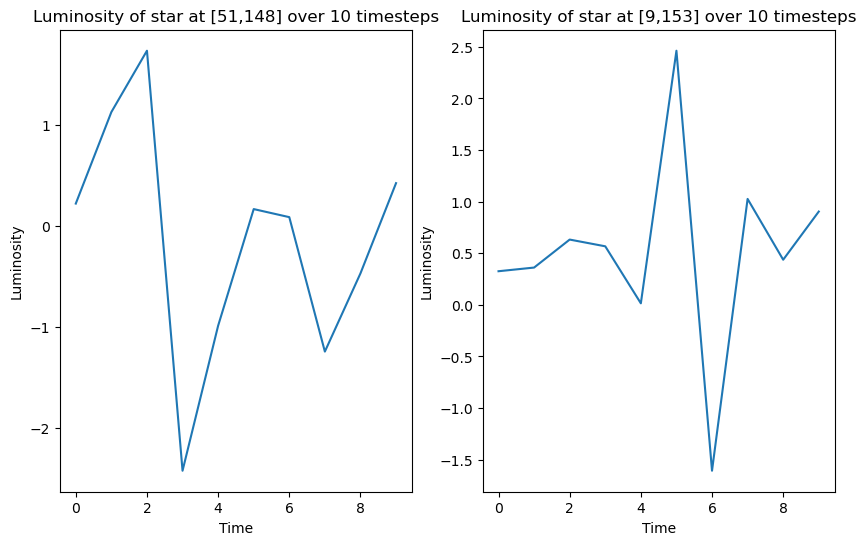

In [101]:
plt.rcParams["figure.figsize"] = (10,6)
fig,ax = plt.subplots(1,2)
ax[0].plot(np.arange(0,10,1),data[51,148,:])
ax[0].title.set_text("Luminosity of star at [51,148] over 10 timesteps")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Luminosity")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Luminosity")
ax[1].plot(np.arange(0,10,1),data[9,153,:])
ax[1].title.set_text("Luminosity of star at [9,153] over 10 timesteps")

From the brightness difference graph we can tell these two points are transient.

4) To find the faintest stars, we generally use the entire image as the background, and the ones with more than 5 sigmas are considered stars or signals. But when we are looking for supernova we must establish the relationship between time and brightness. Since supernovae are short-lived, so it might just appear in one picture, so in this case we should choose the set of brightness differences as the background.

To sum up, the background is a research method, if we have different goals in research, the method we use will be different